In [1]:
%load_ext autoreload

In [350]:
%autoreload 2
from kneed import KneeLocator
import matplotlib.pyplot as plt
from nolitsa import delay
import numpy as np
from scipy.integrate import odeint, simpson
from scipy.signal import argrelextrema
from scipy.spatial.distance import pdist, squareform
from scipy.stats import linregress
import sys
from tqdm.auto import tqdm

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from dynamical_systems_models import embed_signal

# Simulate System

In [234]:
# def L96(x, t, N, dt=0.01):
#     """Lorenz 96 model with constant forcing"""
#     # Setting up vector
#     d = np.zeros(N)
#     # Loops over indices (with operations and Python underflow indexing handling edge cases)
#     for i in range(N):
#         d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
#     return d

# # SIMULATION PARAMETERS
# N = 50
# F = 8
# dt = 0.005
# x0 = F * np.ones(N)  # Initial state (equilibrium)
# x0[0] += 0.01  # Add small perturbation to the first variable
# time_vals = np.arange(0.0, 75.0, dt)

# # SIMULATE
# x = odeint(lambda x, t: L96(x, t, N=N, dt=dt), x0, time_vals)

# # NORMALIZE
# for i in range(N):
#     x[:, i] = (x[:, i] - x[:, i].mean())/x[:, i].std()
    
# projection_dim = 5
# data = x @ np.random.randn(N, projection_dim)

In [847]:
def L63(vec, t, sigma=10, rho=28, beta=8/3):
    x, y, z = vec[0], vec[1], vec[2]
    d = np.zeros(3)
    d[0] = sigma*(y - x)
    d[1] = x*(rho - z) - y
    d[2] = x*y - beta*z
    
    return d

# SIMULATION PARAMETERS
dt = 0.01
# v0 = np.random.randn(3)*0.01
v0 = np.array([0.85957, 1.7318, 1.2865])
# time_vals = np.arange(0.0, 75.0, dt)
# time_vals = np.arange(0.0, 500, dt)
# time_vals = np.arange(0.0, 50, dt)
time_vals = np.arange(0.0, 400, dt)

# SIMULATE
v = odeint(lambda v, t: L63(v, t), v0, time_vals)

# projection_dim = 1
# data = v @ np.random.randn(3, projection_dim)
data = v[1000:, [0]] # remove the transient
# data -= data.mean(axis=0) # remove the mean

# Pick Tau

In [839]:
num_lags = 200
delayed_mis = np.zeros((data.shape[1], num_lags))

iterator = tqdm(total=data.shape[1]*num_lags)
for i in range(data.shape[1]):
    for lag in range(num_lags):
        delayed_mis[i, lag] = delay.mi(data[:data.shape[0]-lag, i], data[lag:, i], bins=64)
        
        iterator.update()
iterator.close()

  0%|          | 0/200 [00:00<?, ?it/s]

In [840]:
tau = argrelextrema(delayed_mis.mean(axis=0), np.less)[0][0]

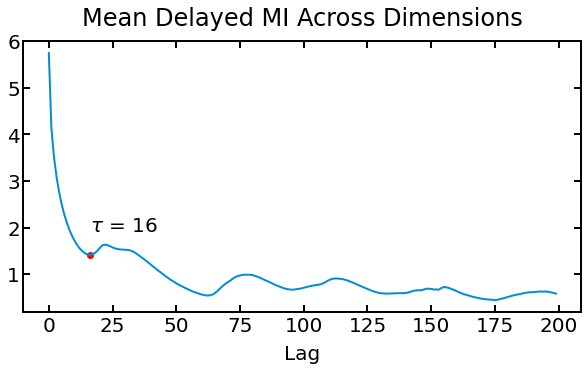

In [841]:
plt.plot(delayed_mis.mean(axis=0))
plt.scatter(tau, delayed_mis.mean(axis=0)[tau], c='red')
plt.text(tau, delayed_mis.mean(axis=0)[tau] + 0.5, fr"$\tau$ = {tau}" )
plt.xlabel('Lag')
plt.title("Mean Delayed MI Across Dimensions")
plt.show()

In [848]:
tau = 1
data = data[np.arange(0, data.shape[0], tau)]

In [849]:
dt_eff = tau*dt
dt_eff

0.01

# Functions

In [850]:
def embed_dists(data, k, m=None):
    # delay embedding
    Y_k = embed_signal(data, k, 1, direction='reverse')
    
    if m is None:
        Y_k_m = Y_k
    else:
        if m > Y_k.shape[1]:
            raise ValueError(f"m = {m}, and k = {k} so Y_k has points with dimension {Y_k.shape[1]}. Must have {m <= Y_k.shape[1]}")
        U, S, Vh = np.linalg.svd(Y_k)
        Y_k_m = U[:, :m]
        Gamma_m_inv = np.diag(S[:m]) @ Vh[:m]
    
    # compute pairwise distances
    pairwise_dists = pdist(Y_k_m, 'euclidean')
    pairwise_dists = squareform(pairwise_dists)
    
    if m is None:
        return Y_k_m, pairwise_dists
    else:
        return Y_k_m, pairwise_dists, Gamma_m_inv
    
def compute_error_over_N_b(data, k, N_b_vals, tau_pred=1, num_preds=500):
    
    Y_k, pairwise_dists = embed_dists(data, k)
    
    pred_ts = np.random.choice(np.arange(Y_k.shape[0] - tau_pred), size=(np.min([num_preds, Y_k.shape[0] - tau_pred]), ), replace=False)
    
    errors = np.zeros((len(N_b_vals), len(pred_ts), data.shape[1]))
    
    for t_ind, t_prime in enumerate(pred_ts):
        # find transverse nearest neighbors
        min_inds = argrelextrema(pairwise_dists[t_prime], np.less)[0]
        irrelevant_ind = np.where(pairwise_dists[t_prime] == 0)[0][0]
        min_inds = np.delete(min_inds, np.where(min_inds == irrelevant_ind)[0]) 
        sorted_neighbor_indices = min_inds[np.argsort(pairwise_dists[t_prime][min_inds])]

        # estimate
        estimation_indices = sorted_neighbor_indices + tau_pred
        estimation_indices = estimation_indices[estimation_indices < Y_k.shape[0]]
        y_true = Y_k[t_prime + tau_pred][:data.shape[1]]
        for N_b_ind, N_b in enumerate(N_b_vals):
            x_est = Y_k[estimation_indices[:N_b]].mean(axis=0)
            y_est = x_est[:data.shape[1]]
        
            errors[N_b_ind, t_ind] = (y_est - y_true)**2
    
    return errors.mean(axis=1).sum(axis=1)

def compute_error_over_tau_pred(data, k, N_b, tau_pred_vals, num_preds=500):
    
    Y_k, pairwise_dists = embed_dists(data, k)
    
    max_tau_pred = np.max(tau_pred_vals)
    pred_ts = np.random.choice(np.arange(Y_k.shape[0] - max_tau_pred), size=(np.min([num_preds, Y_k.shape[0] - max_tau_pred]), ), replace=False)
    
    errors = np.zeros((len(tau_pred_vals), len(pred_ts), data.shape[1]))
    
    for t_ind, t_prime in enumerate(pred_ts):
        # find transverse nearest neighbors
        min_inds = argrelextrema(pairwise_dists[t_prime], np.less)[0]
        irrelevant_ind = np.where(pairwise_dists[t_prime] == 0)[0][0]
        min_inds = np.delete(min_inds, np.where(min_inds == irrelevant_ind)[0]) 
        sorted_neighbor_indices = min_inds[np.argsort(pairwise_dists[t_prime][min_inds])]

        for tau_pred_ind, tau_pred in enumerate(tau_pred_vals):
            # estimate
            estimation_indices = sorted_neighbor_indices + tau_pred
            estimation_indices = estimation_indices[estimation_indices < Y_k.shape[0]]
            y_true = Y_k[t_prime + tau_pred][:data.shape[1]]
            x_est = Y_k[estimation_indices[:N_b]].mean(axis=0)
            y_est = x_est[:data.shape[1]]

            errors[tau_pred_ind, t_ind] = (y_est - y_true)**2
    
    return errors.mean(axis=1).sum(axis=1)

def compute_error_over_tau_pred_with_m(data, k, m, N_b, tau_pred_vals, num_preds=500):
    
    Y_k_m, pairwise_dists, Gamma_m_inv = embed_dists(data, k, m)
    
    max_tau_pred = np.max(tau_pred_vals)
    pred_ts = np.random.choice(np.arange(Y_k_m.shape[0] - max_tau_pred), size=(np.min([num_preds, Y_k_m.shape[0] - max_tau_pred]), ), replace=False)
    
    errors = np.zeros((len(tau_pred_vals), len(pred_ts), data.shape[1]))
    
    for t_ind, t_prime in enumerate(pred_ts):
        # find transverse nearest neighbors
        min_inds = argrelextrema(pairwise_dists[t_prime], np.less)[0]
        irrelevant_ind = np.where(pairwise_dists[t_prime] == 0)[0][0]
        min_inds = np.delete(min_inds, np.where(min_inds == irrelevant_ind)[0]) 
        sorted_neighbor_indices = min_inds[np.argsort(pairwise_dists[t_prime][min_inds])]

        for tau_pred_ind, tau_pred in enumerate(tau_pred_vals):
            # estimate
            estimation_indices = sorted_neighbor_indices + tau_pred
            estimation_indices = estimation_indices[estimation_indices < Y_k_m.shape[0]]
            y_true = data[(k - 1) + t_prime + tau_pred]
            x_est = Y_k_m[estimation_indices[:N_b]].mean(axis=0)
            y_est = (x_est @ Gamma_m_inv)[:data.shape[1]]

            errors[tau_pred_ind, t_ind] = (y_est - y_true)**2
    
    return errors.mean(axis=1).sum(axis=1)

def estimate_T_pred(curve, tau_pred_vals):
    integral = np.zeros(len(curve))
    for i in range(1, len(curve)):
        integral[i] = simpson(curve[:i], tau_pred_vals[:i])

    s_ind = KneeLocator(np.arange(len(curve)), curve, curve='concave', direction='increasing').knee
    tau_s_vals = [tau_pred_vals[s_ind]]
    e_s_vals = [curve[s_ind]]
    delta_vals = []
    for i in range(10):
        lr = linregress(tau_pred_vals[s_ind:], integral[s_ind:])
        e_s_new = lr.slope
        ratio = e_s_new/e_s_vals[-1]
        if ratio >= 0.9 and ratio <= 1.1:
            if i == 0:
                delta_vals.append(-lr.intercept)
            break
        e_s_vals.append(e_s_new)
        delta_vals.append(-lr.intercept)
        s_ind = ((curve[:-5] - e_s_new)**2).argmin() # leave out last few points
        tau_s_vals.append(tau_pred_vals[s_ind])
    
    e_s = e_s_vals[-1]
    delta = delta_vals[-1]
    T_pred = delta/e_s

    return T_pred, e_s, delta


## Pick $N_b$

In [851]:
tau_pred = 1
max_k = 30
max_N_b = 40
num_preds = 500

N_b_vals = np.arange(1, max_N_b + 1, 1)
k_vals = np.arange(1, max_k + 1)

E_1 = np.zeros((len(k_vals), len(N_b_vals)))

for i, k in tqdm(enumerate(k_vals), total=len(k_vals)):
    E_1[i, :] = compute_error_over_N_b(data, k, N_b_vals, tau_pred=tau_pred, num_preds=num_preds)

  0%|          | 0/30 [00:00<?, ?it/s]

In [852]:
min_ind = argrelextrema(E_1.mean(axis=0), np.less)[0][0]
N_b_star = N_b_vals[min_ind]

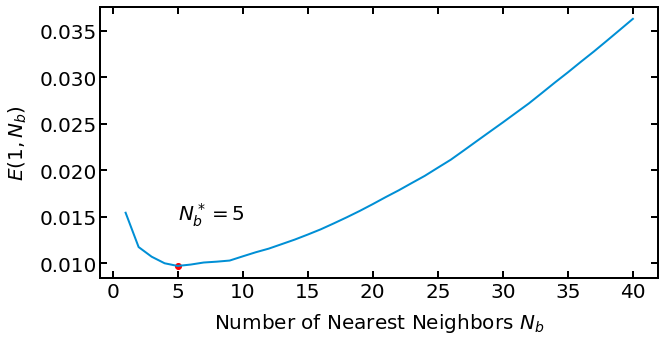

In [854]:
plt.plot(N_b_vals, E_1.mean(axis=0))
plt.scatter(N_b_star, E_1.mean(axis=0)[min_ind], c='r')
plt.text(N_b_star, E_1.mean(axis=0)[min_ind]*1.5, f"$N_b^* = ${N_b_star}")
plt.xlabel("Number of Nearest Neighbors $N_b$")
plt.ylabel("$E(1, N_b)$")
plt.show()

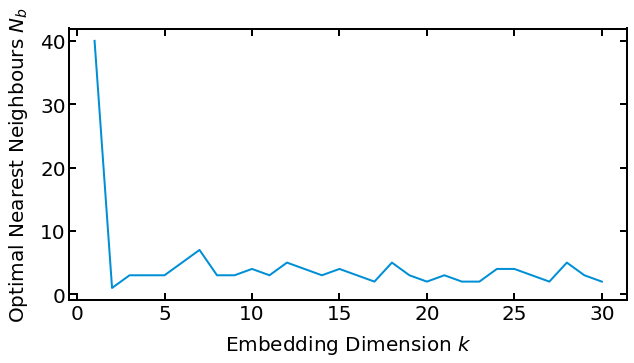

In [855]:
picked_N_b_vals = N_b_vals[E_1.argmin(axis=1)]
plt.plot(k_vals, picked_N_b_vals)
plt.xlabel('Embedding Dimension $k$')
plt.ylabel('Optimal Nearest Neighbours $N_b$')
# plt.xlim([5, 15])
# plt.ylim([0, 10])
plt.show()

## Pick $K^*$

In [856]:
max_tau_pred = 50
num_preds = 500

k_vals = np.arange(1, max_k + 1)
tau_pred_vals = np.arange(1, max_tau_pred + 1)

E_tau = np.zeros((len(k_vals), len(tau_pred_vals)))

for i, k in tqdm(enumerate(k_vals), total=len(k_vals)):
    E_tau[i, :] = compute_error_over_tau_pred(data, k, N_b_star, tau_pred_vals, num_preds=num_preds)

  0%|          | 0/30 [00:00<?, ?it/s]

In [857]:
T_preds = np.zeros(E_tau.shape[0])
e_s_vals = np.zeros(T_preds.shape)
delta_vals = np.zeros(T_preds.shape)
for i in tqdm(range(E_tau.shape[0])):
    T_preds[i], e_s_vals[i], delta_vals[i] = estimate_T_pred(E_tau[i], tau_pred_vals)

  0%|          | 0/30 [00:00<?, ?it/s]

In [858]:
# fig, axs = plt.subplots(5, 6, figsize=(30, 20))

# for i in range(30):
#     ax = axs[int(i/6)][i % 6]
#     ax.plot(E_tau[i])
#     ax.axhline(e_s_vals[i], linestyle='--', c='k')
# plt.show()

In [859]:
# k = 5
# plt.plot(tau_pred_vals, E_tau[k - 1])
# plt.ylabel(r"$E(\tau)$")
# plt.xlabel(r"$\tau$")
# plt.title(fr"$E(\tau)$ for $k = ${k}")
# plt.axhline(e_s, linestyle='--', c='k', label='$e_s$')
# plt.axvline(T_pred, linestyle='--', c='red', label=r"$T_{pred} = \frac{\Delta}{e_s}$")
# plt.legend()
# plt.show()

In [860]:
k_star = KneeLocator(k_vals, T_preds, curve='concave', direction='increasing').knee

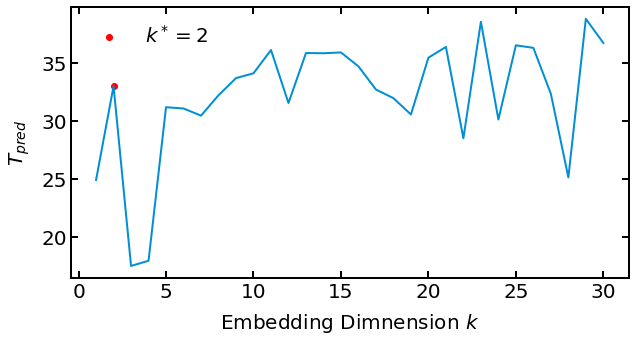

In [861]:
plt.plot(k_vals, T_preds)
plt.scatter(k_star, T_preds[k_vals == k_star], c='red', label=f'$k^* = {k_star}$')
plt.xlabel("Embedding Dimnension $k$")
plt.ylabel("$T_{pred}$")
plt.legend()
plt.show()

## Pick $m$

In [862]:
m_vals = np.arange(1, np.min([10, data.shape[1]*k_star]) + 1)
max_tau_pred = 50
num_preds = 500

tau_pred_vals = np.arange(1, max_tau_pred + 1)
E_tau_m = np.zeros((len(m_vals), len(tau_pred_vals)))
for i, m in tqdm(enumerate(m_vals), total=len(m_vals)):
    E_tau_m[i] = compute_error_over_tau_pred_with_m(data, k_star, m, N_b_star, tau_pred_vals, num_preds=num_preds)

  0%|          | 0/2 [00:00<?, ?it/s]

In [863]:
T_preds = np.zeros(E_tau_m.shape[0])
e_s_vals = np.zeros(T_preds.shape)
delta_vals = np.zeros(T_preds.shape)
for i in tqdm(range(E_tau_m.shape[0])):
    T_preds[i], e_s_vals[i], delta_vals[i] = estimate_T_pred(E_tau_m[i], tau_pred_vals)

  0%|          | 0/2 [00:00<?, ?it/s]

In [864]:
# m_star = KneeLocator(m_vals, T_preds, curve='concave', direction='increasing').knee
min_inds = argrelextrema(T_preds, np.greater)[0]
if len(min_inds) == 0:
    min_ind = -1
else:
    min_ind = min_inds[0]
m_star = m_vals[min_ind]

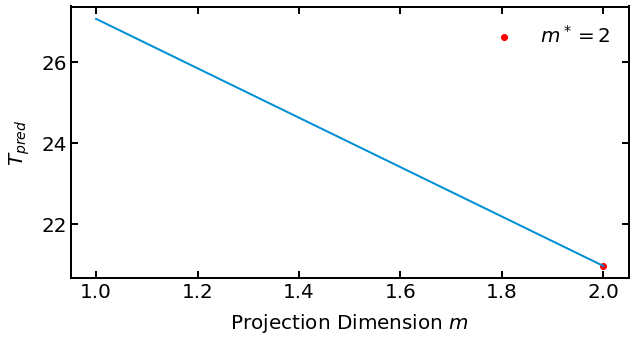

In [865]:
plt.plot(m_vals, T_preds)
plt.scatter(m_star, T_preds[m_vals == m_star], c='red', label=f'$m^* = {m_star}$')
plt.xlabel("Projection Dimension $m$")
plt.ylabel("$T_{pred}$")
plt.legend()
plt.show()

In [866]:
print(f"Picked variables: N_b_star = {N_b_star}, k_star = {k_star}, m_star = {m_star}")

Picked variables: N_b_star = 5, k_star = 2, m_star = 2


## Embed Whole Time Series

In [867]:
X, pairwise_dists, Gamma_m_inv = embed_dists(data, k_star, m_star)

## Find Minimum Period Recurrence Distance

In [868]:
N = X.shape[0]
T_max = 100
r_max = N - T_max

In [869]:
epsilon_r_t = np.zeros((r_max, T_max))

In [870]:
for t in tqdm(range(1, T_max + 1)):
    epsilon_r_t[:, t - 1] = np.sort(pairwise_dists[np.arange(r_max), np.arange(r_max) + t])

  0%|          | 0/100 [00:00<?, ?it/s]

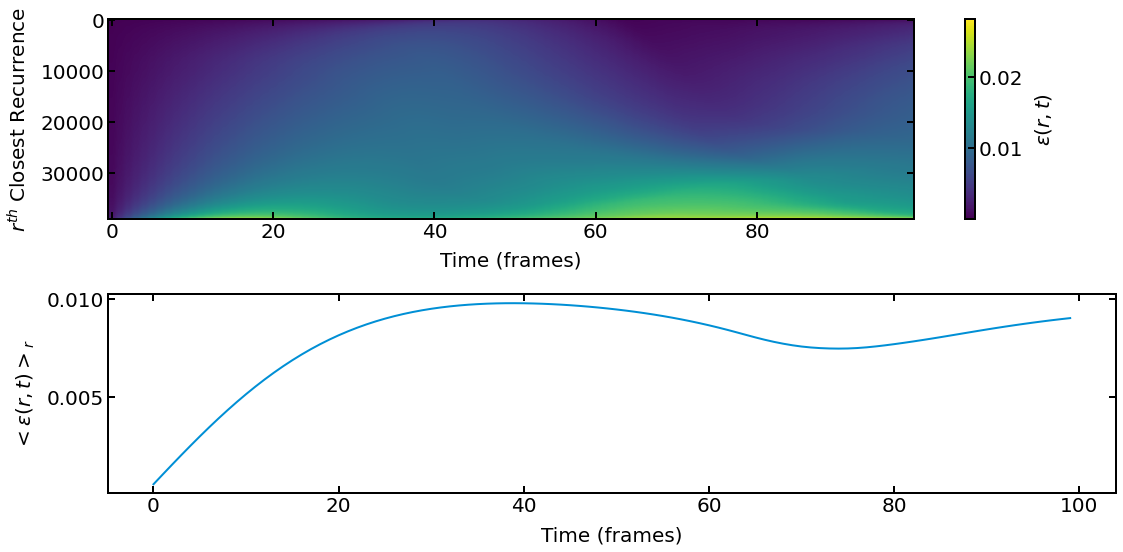

In [871]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.imshow(epsilon_r_t, aspect='auto')
plt.colorbar(label=r"$\epsilon(r, t)$")
plt.ylabel(r"$r^{th}$ Closest Recurrence")
plt.xlabel('Time (frames)')
plt.subplot(2, 1, 2)
plt.plot(epsilon_r_t.mean(axis=0))
plt.xlabel('Time (frames)')
plt.ylabel(r"$<\epsilon(r, t)>_r$")
plt.tight_layout()
plt.show()

In [872]:
min_ind = argrelextrema(epsilon_r_t[m_star, :], np.less)[0][0]
p_min = min_ind + 1
epsilon_star = epsilon_r_t[m_star, :][min_ind]

In [873]:
# min_ind = argrelextrema(epsilon_r_t.mean(axis=0), np.less)[0][0]
# p_min = min_ind + 1
# epsilon_star = epsilon_r_t.mean(axis=0)[min_ind]

## Estimate Jacobians

In [874]:
B_0 = X[:-1]
B_1 = X[1:]

In [875]:
weights = np.exp(-pairwise_dists/epsilon_star)

In [876]:
Js = np.zeros((B_0.shape[0], X.shape[1], X.shape[1]))
for i in tqdm(range(B_0.shape[0])):
    B_0_w = B_0 * weights[i][:-1][:, np.newaxis]
    B_1_w = B_1 * weights[i][:-1][:, np.newaxis]
    Js[i] = np.linalg.pinv(B_0_w) @ B_1_w

  0%|          | 0/38998 [00:00<?, ?it/s]

In [877]:
def compute_lyaps(Js, verbose=False):
    T, n = Js.shape[0], Js.shape[1]
    old_Q = np.eye(n)
    lexp_all = np.zeros((T, n))
    lexp_all[:] = np.nan
    lexp = np.zeros(n)
    lexp_counts = np.zeros(n)
    for t in tqdm(range(T), disable=not verbose):
        # QR-decomposition of Js[t] * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(Js[t], old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
#         print(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)
        old_Q = mat_Q
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)

#         print(diag_R)
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape, dtype="float32")
        lexp_i[idx] = np.log(diag_R[idx])
#         lexp_i[np.where(diag_R == 0)] = np.inf
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1
        lexp_all[t, idx] = lexp_i[idx]

        # it may happen that all R-matrices contained zeros => exponent really has
        # to be -inf

        # normalize exponents over number of individual mat_Rs
#         idx = np.where(lexp_counts > 0)
        #lexp[idx] /= lexp_counts[idx]
#         lexp[np.where(lexp_counts == 0)] = np.inf

    return np.divide(lexp, lexp_counts), lexp_all

In [878]:
lyaps, lexp_all = compute_lyaps(Js, verbose=True)

  0%|          | 0/38998 [00:00<?, ?it/s]

In [879]:
dt_eff

0.01

In [880]:
lyaps /= dt_eff

In [881]:
lyaps

array([ 6.17350819, -9.87467951])

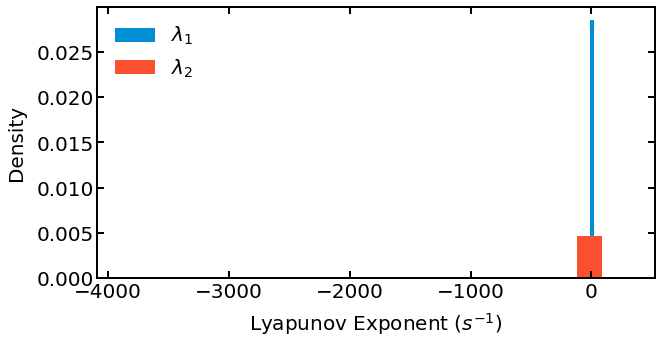

In [882]:
for i in range(lexp_all.shape[1]):
    plt.hist(lexp_all[:, i][~np.isnan(lexp_all[:, i])]/dt_eff, label=fr'$\lambda_{i + 1}$', density=True, bins=20)
plt.legend()
plt.xlabel("Lyapunov Exponent ($s^{-1}$)")
plt.ylabel("Density")
plt.show()